# Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)

### **References Used:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html
    - https://maartengr.github.io/BERTopic/getting_started/distribution/distribution.html#example
    - https://maartengr.github.io/BERTopic/getting_started/topicrepresentation/topicrepresentation.html#update-topic-representation-after-training


In [1]:
import spacy
from tqdm import tqdm
from collections import Counter
import pandas as pd

# imports
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark') 

sou = pd.read_csv('data/SOTU.csv')
nlp = spacy.load("en_core_web_sm")

In [2]:
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

/home/jovyan/envs/sotu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LDA

To create and analyze potential topics associated with the speeches, we will first use the LDA method and package.
- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

In [14]:
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [15]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

In [16]:
processed_docs

0      [speak, president, present, prepared, remark, ...
1      [president, speaker, point, president, turn, f...
2      [president, thank, thank, thank, madam, speake...
3      [president, thank, thank, thank, good, mitch, ...
4      [president, thank, thank, thank, madam, speake...
                             ...                        
241    [fellow, citizen, senate, house, representativ...
242    [fellow, citizen, senate, house, representativ...
243    [fellow, citizen, senate, house, representativ...
244    [fellow, citizen, senate, house, representativ...
245    [fellow, citizen, senate, house, representativ...
Name: Text, Length: 246, dtype: object

In [17]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
sou['tokens'] = processed_docs
#Gensim Dictionary object maps each word to their unique ID:
dictionary = Dictionary(sou['tokens'])
#print(dictionary.token2id)
#dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

#create sparse vector (i, j) where i is dictionary id and j is number of occurences of that distinct word (?)
corpus = [dictionary.doc2bow(doc) for doc in sou['tokens']]

In [24]:
# train LDA model with 18 topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, random_state=42, passes=10)

In [25]:
# print the top 10 words for each topic
lda_model.print_topics(-1)

[(0,
  '0.011*"government" + 0.009*"year" + 0.007*"federal" + 0.007*"country" + 0.007*"congress" + 0.006*"public" + 0.005*"system" + 0.005*"increase" + 0.005*"work" + 0.005*"economic"'),
 (1,
  '0.005*"congress" + 0.005*"year" + 0.004*"peace" + 0.004*"great" + 0.004*"time" + 0.004*"states" + 0.003*"mention" + 0.003*"national" + 0.003*"economy" + 0.003*"government"'),
 (2,
  '0.015*"year" + 0.012*"america" + 0.011*"people" + 0.009*"work" + 0.009*"american" + 0.007*"world" + 0.007*"americans" + 0.006*"nation" + 0.006*"help" + 0.006*"time"'),
 (3,
  '0.008*"united" + 0.008*"states" + 0.007*"government" + 0.006*"public" + 0.005*"citizen" + 0.005*"country" + 0.005*"measure" + 0.004*"great" + 0.004*"good" + 0.004*"present"'),
 (4,
  '0.003*"government" + 0.002*"year" + 0.002*"congress" + 0.002*"people" + 0.002*"united" + 0.002*"country" + 0.001*"states" + 0.001*"great" + 0.001*"state" + 0.001*"time"'),
 (5,
  '0.007*"nation" + 0.006*"right" + 0.006*"service" + 0.005*"national" + 0.005*"congr

In [26]:
# print the topic distribution for the first speech
sou['Text'][0]
lda_model[corpus][0]

[(2, np.float32(0.99972975))]

The first speech is 99% belonging to topic 2!

In [31]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()

lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)


In [78]:
#save to outputs
pyLDAvis.save_html(lda_display, 'outputs/lda_topics.html')

### BERTopic
We will also conduct topic analysis using the BERTopic method and package. We will run through the following steps:
- Train a BERTopic model with a `min_topic_size` of 3 
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics

In [47]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [66]:
docs = sou['Text'].to_list()

In [67]:
# train the model - this takes about 30 seconds
topic_model = BERTopic(min_topic_size=3)
topics, probs = topic_model.fit_transform(docs)


# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)
vectorizer_model = CountVectorizer(stop_words="english")
topic_model.update_topics(docs, vectorizer_model=vectorizer_model) 

In [52]:
# output the top 10 words for each topic - hint see get_topic_info
topic_model.get_topic_info()['Representation']

0     [government, states, congress, united, people,...
1     [world, people, new, american, years, america,...
2     [states, government, united, congress, public,...
3     [government, states, united, year, congress, l...
4     [america, americans, american, people, thats, ...
5     [states, united, government, public, mexico, c...
6     [world, peace, nations, soviet, nation, econom...
7     [states, government, united, congress, public,...
8     [states, government, congress, united, year, t...
9     [government, states, united, public, congress,...
10    [government, states, public, general, united, ...
11    [states, government, constitution, country, ge...
12    [new, people, children, american, america, wor...
13    [federal, tax, people, america, budget, spendi...
14    [government, states, united, congress, year, c...
15    [government, law, public, country, national, w...
16    [national, reduction, country, federal, govern...
17    [states, government, united, constitution,

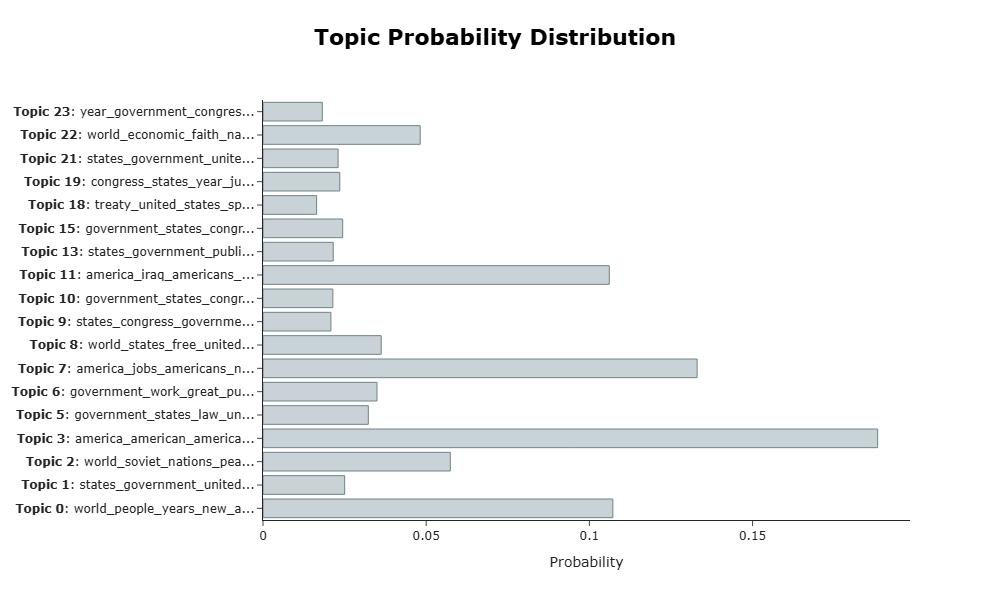

In [74]:
# output the topic distribution for the first speech
topic_distr, _ = topic_model.approximate_distribution(docs)
first_speech_viz = topic_model.visualize_distribution(topic_distr[1])

#save first speech topic distribution to outputs
first_speech_viz.write_html("outputs/BERTopic_first_speech_viz.html")
first_speech_viz

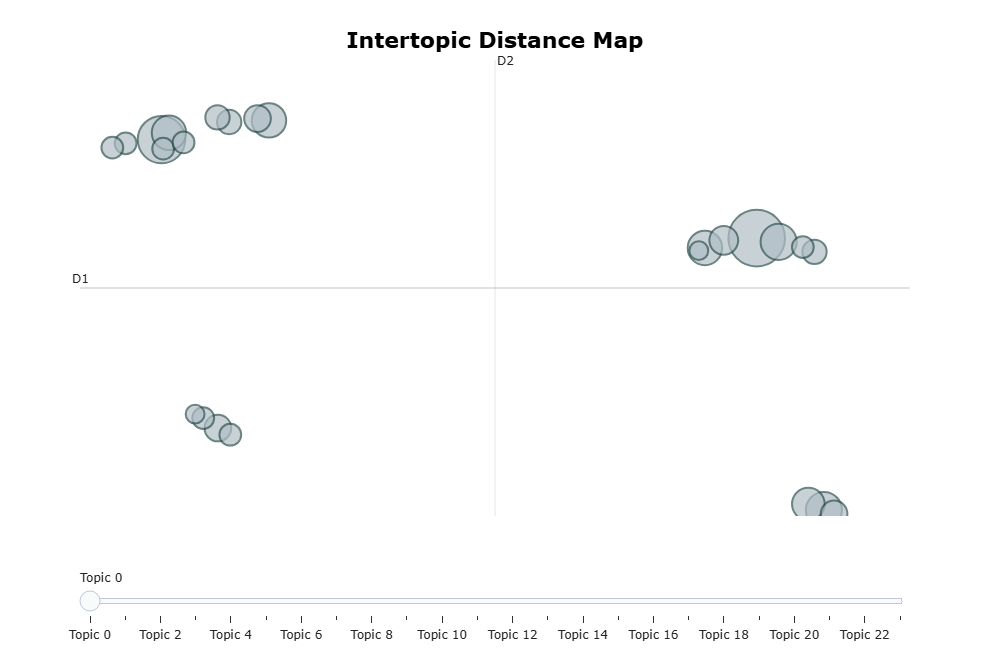

In [75]:
# run this cell to visualize the topics
viz_topics = topic_model.visualize_topics()

#save topic visualizations to output
viz_topics.write_html("outputs/BERTopic_topics_viz.html")
viz_topics

## Discussion and Reflections

The topic distribution across the two dimensional PCA is notably different for the LDA (bag of words) and BERTopic (semantic similarity) approaches. The LDA distribution appears to have larger clusters on the right quadrant of the analyses, with significantly smaller clusters on the left quadrant. On the other hand, the BERTopic distributions land in each quadrant of the PCA grid, with more even distribution between each in terms of cluster size. This demonstrates how the two approaches use different attributes of the speeches and different algorithms to conclude topic summaries and distributions.